In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statistics
import tqdm
import xgboost as xgb

from imblearn.under_sampling import NearMiss
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
#from yellowbrick.model_selection import FeatureImportances
import matplotlib.gridspec as gridspec
#from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Shortcut to duplicate current line

In [29]:
%%javascript

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

TW = "training wheels" dataset, sample of 50,000 to permit more experimentation with modelling on a limited timeline

In [30]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)
    

tw = selected_columns.sample(100000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)

X = all features (57) ,
Xs = all features on tw (sampled) dataset

y = target (income above or below 50k) ,
ys = sampled target    

Z = small selection of features (8) ,
Zs = sampled selected features

In [31]:
X, Xs, y, ys = selected_columns.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), ttw.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), selected_columns.filter(['>50K']), ttw.filter(['>50K'])
Z, Zs = selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), ttw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

train_df = X_train.copy()
train_df['$$$'] = y_train

Z_train, Z_test, q_train, q_test = train_test_split(Z, y, test_size=0.2, random_state=42)
Zs_train, Zs_test, qs_train, qs_test = train_test_split(Zs, ys, test_size=0.2, random_state=42)

# Scaling, although it seems to worsen the results for most models
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xs_train_scaled = std.fit_transform(Xs_train)

Z_train_scaled = std.fit_transform(Z_train)
Zs_train_scaled = std.fit_transform(Zs_train)

In [32]:
# from sklearn import preprocessing
# Zs = preprocessing.scale(Z)

In [29]:
edu = pd.get_dummies(Z['EDUC'], prefix='edu')
edu

occ = pd.get_dummies(Z['OCC'], prefix='occ')
occ

degfield = pd.get_dummies(Z['DEGFIELD'], prefix='deg')
degfield

sex = pd.get_dummies(Z['SEX'], prefix='sex', drop_first=True)
sex

leftover = Z.drop(columns=['EDUC', 'OCC', 'DEGFIELD', 'SEX'])
leftover

W = pd.concat([leftover, occ, sex, degfield, edu], axis=1)
W

,UHRSWORK,VALUEH,AGE,TRANWORK,occ_0.0,occ_10.0,occ_20.0,occ_40.0,occ_51.0,occ_52.0,...,edu_1.0,edu_2.0,edu_3.0,edu_4.0,edu_5.0,edu_6.0,edu_7.0,edu_8.0,edu_10.0,edu_11.0
2292,40.0,130000.0,70.0,70.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2293,40.0,130000.0,71.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2294,40.0,50000.0,60.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2295,40.0,50000.0,50.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2297,0.0,50000.0,60.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214529,30.0,275000.0,55.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3214530,0.0,275000.0,77.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3214531,40.0,260000.0,41.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3214532,50.0,260000.0,34.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [33]:
edu = pd.get_dummies(Zs['EDUC'], prefix='edu')
edu

occ = pd.get_dummies(Zs['OCC'], prefix='occ')
occ

degfield = pd.get_dummies(Zs['DEGFIELD'], prefix='deg')
degfield

sex = pd.get_dummies(Zs['SEX'], prefix='sex', drop_first=True)
sex

leftover = Zs.drop(columns=['EDUC', 'OCC', 'DEGFIELD', 'SEX'])
leftover

Ws = pd.concat([leftover, occ, sex, degfield, edu], axis=1)
Ws

Ws_train, Ws_test, ys_train, ys_test = train_test_split(Ws, ys, test_size=0.2, random_state=42)

### Class imbalance...

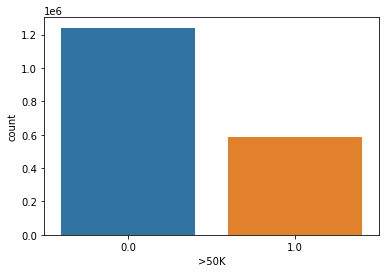

In [31]:
# sns.countplot(selected_columns['>50K'])

### Near Miss undersampling

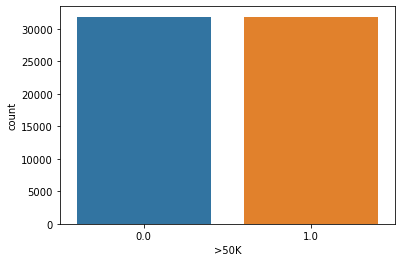

In [26]:
# nm1 = NearMiss(version=1, sampling_strategy='auto', n_jobs=-1)
# resampled_Zs, resampled_ys = nm1.fit_resample(Zs, ys)

# sns.countplot(resampled_ys['>50K'])

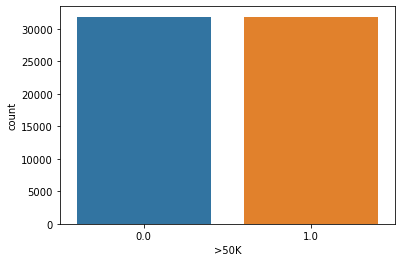

In [33]:
# nm1 = NearMiss(version=1, sampling_strategy='auto', n_jobs=-1)
# resampled_Ws, resampled_ys = nm1.fit_resample(Ws, ys)

# sns.countplot(resampled_ys['>50K'])

#### New train/test holdout for undersampled data

In [38]:
# Ws_train, Ws_test, ys_train, ys_test = train_test_split(resampled_Ws, resampled_ys, test_size=0.2, random_state=42)
# Zr_train, Zr_test, qr_train, qr_test = train_test_split(resampled_Z, resampled_y, test_size=0.2, random_state=42)

### KNN with Zs

In [34]:
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn.fit(Ws_train, ys_train)
print("Training: {:6.2f}%".format(100*knn.score(Ws_train, ys_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Ws_test, ys_test)))

Training:  74.38%
Test set:  71.50%


<ipython-input-34-f49b1ad9b25a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Ws_train, ys_train)


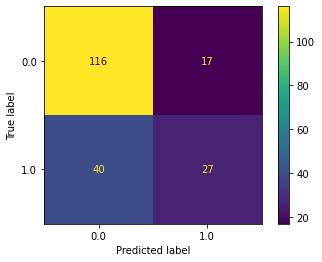

In [35]:
plot_confusion_matrix(knn, Ws_test, ys_test)

In [37]:
ys_predict = knn.predict(Ws_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.6136,   Recall: 0.4030


### Logistic Regression with Zs

In [38]:
logit = LogisticRegression()
logit.fit(Ws_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Ws_train, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Ws_test, ys_test)))

The score for logistic regression is
Training:  69.00%
Test set:  66.50%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


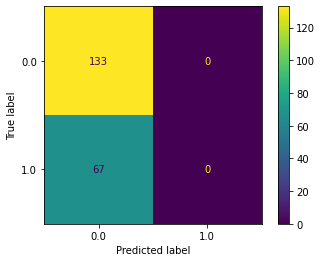

In [39]:
plot_confusion_matrix(logit, Ws_test, ys_test)

<img src=https://newbiettn.github.io/images/confusion-matrix-noted.jpg width="250">

In [40]:
ys_predict = logit.predict(Ws_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.0000,   Recall: 0.0000


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
Ws_test

,UHRSWORK,VALUEH,AGE,TRANWORK,occ_0.0,occ_10.0,occ_20.0,occ_51.0,occ_52.0,occ_101.0,...,edu_1.0,edu_2.0,edu_3.0,edu_4.0,edu_5.0,edu_6.0,edu_7.0,edu_8.0,edu_10.0,edu_11.0
1955812,0.0,300000.0,68.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1819655,55.0,300000.0,41.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
503034,0.0,50000.0,64.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
817178,25.0,100000.0,46.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2620801,30.0,224000.0,36.0,70.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147854,0.0,80000.0,19.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2631026,50.0,375000.0,57.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1002031,0.0,25000.0,75.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
482563,40.0,450000.0,42.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [51]:
Ws_test.iloc[:, 0]

1955812     0.0
1819655    55.0
503034      0.0
817178     25.0
2620801    30.0
           ... 
3147854     0.0
2631026    50.0
1002031     0.0
482563     40.0
456195     40.0
Name: UHRSWORK, Length: 200, dtype: float64

roc_auc_score for Random Forest:  0.13730221075075752
roc_auc_score for Random Forest 0.7503086073392436


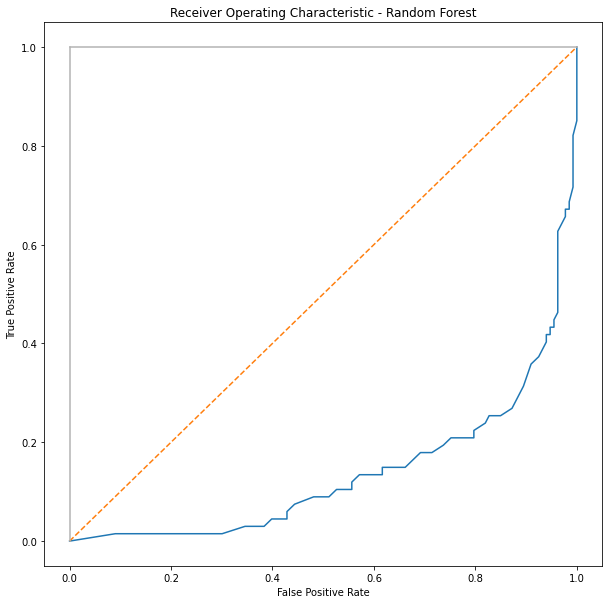

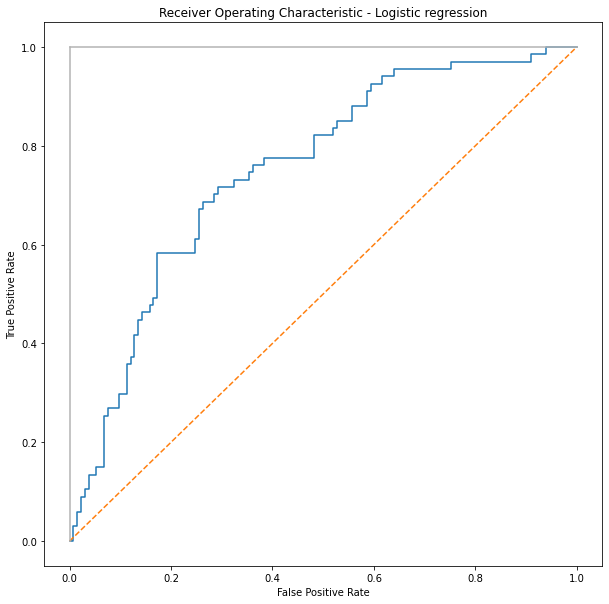

In [61]:
ys_score1 = rf.predict_proba(Ws_test)[:, 0]
ys_score2 = logit.predict_proba(Ws_test)[:, 0]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(ys_test, ys_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(ys_test, ys_score2)
print('roc_auc_score for Random Forest: ',
     roc_auc_score(ys_test, ys_score1))
print('roc_auc_score for Logistic Regression: ',
      roc_auc_score(ys_test, ys_score2))

# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest

In [53]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(Ws_train, ys_train)
print("The r2 score for random forest is")
print("Training: {:6.2f}%".format(100*rf.score(Ws_train, ys_train)))
print("Test set: {:6.2f}%".format(100*rf.score(Ws_test, ys_test)))

The r2 score for random forest is
Training: 100.00%
Test set:  82.50%


<ipython-input-53-7f545533e47c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Ws_train, ys_train)


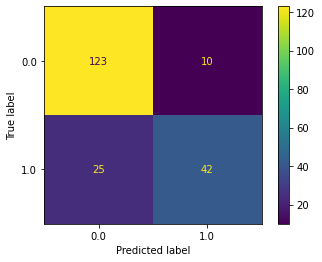

In [54]:
plot_confusion_matrix(rf, Ws_test, ys_test)

In [55]:
ys_predict = rf.predict(Ws_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.8077,   Recall: 0.6269


In [60]:
eval_metrics = ['rmse', 'rmsle', 'mae', 'logloss', 'error', 'auc', 'aucpr', 'map', 'poisson-nloglik']

for metric in eval_metrics:
    clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
    clf_xgb.fit(Ws_train, ys_train, verbose=True, early_stopping_rounds=10, eval_metric=metric, eval_set=[(Ws_test, ys_test)])


[0]	validation_0-rmse:0.45269
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.42668
[2]	validation_0-rmse:0.41234
[3]	validation_0-rmse:0.40415
[4]	validation_0-rmse:0.39879
[5]	validation_0-rmse:0.39535
[6]	validation_0-rmse:0.39328
[7]	validation_0-rmse:0.39140
[8]	validation_0-rmse:0.39034
[9]	validation_0-rmse:0.38915
[10]	validation_0-rmse:0.38836
[11]	validation_0-rmse:0.38749
[12]	validation_0-rmse:0.38688
[13]	validation_0-rmse:0.38634
[14]	validation_0-rmse:0.38590
[15]	validation_0-rmse:0.38521
[16]	validation_0-rmse:0.38476
[17]	validation_0-rmse:0.38416
[18]	validation_0-rmse:0.38379
[19]	validation_0-rmse:0.38325
[20]	validation_0-rmse:0.38280
[21]	validation_0-rmse:0.38217
[22]	validation_0-rmse:0.38189
[23]	validation_0-rmse:0.38173
[24]	validation_0-rmse:0.38144
[25]	validation_0-rmse:0.38126
[26]	validation_0-rmse:0.38093
[27]	validation_0-rmse:0.38083
[28]	validation_0-rmse:0.38064
[29]	validation_0-rmse:0.38045
[30]	validation

[58]	validation_0-mae:0.29051
[59]	validation_0-mae:0.29037
[60]	validation_0-mae:0.29011
[61]	validation_0-mae:0.28990
[62]	validation_0-mae:0.28960
[63]	validation_0-mae:0.28952
[64]	validation_0-mae:0.28936
[65]	validation_0-mae:0.28914
[66]	validation_0-mae:0.28900
[67]	validation_0-mae:0.28888
[68]	validation_0-mae:0.28875
[69]	validation_0-mae:0.28865
[70]	validation_0-mae:0.28860
[71]	validation_0-mae:0.28840
[72]	validation_0-mae:0.28826
[73]	validation_0-mae:0.28805
[74]	validation_0-mae:0.28789
[75]	validation_0-mae:0.28779
[76]	validation_0-mae:0.28744
[77]	validation_0-mae:0.28658
[78]	validation_0-mae:0.28626
[79]	validation_0-mae:0.28616
[80]	validation_0-mae:0.28602
[81]	validation_0-mae:0.28592
[82]	validation_0-mae:0.28589
[83]	validation_0-mae:0.28577
[84]	validation_0-mae:0.28577
[85]	validation_0-mae:0.28566
[86]	validation_0-mae:0.28546
[87]	validation_0-mae:0.28538
[88]	validation_0-mae:0.28509
[89]	validation_0-mae:0.28504
[90]	validation_0-mae:0.28490
[91]	valid

[49]	validation_0-auc:0.87718
[50]	validation_0-auc:0.87726
[51]	validation_0-auc:0.87743
[52]	validation_0-auc:0.87747
[53]	validation_0-auc:0.87753
[54]	validation_0-auc:0.87751
[55]	validation_0-auc:0.87760
[56]	validation_0-auc:0.87768
[57]	validation_0-auc:0.87766
[58]	validation_0-auc:0.87772
[59]	validation_0-auc:0.87777
[60]	validation_0-auc:0.87798
[61]	validation_0-auc:0.87811
[62]	validation_0-auc:0.87827
[63]	validation_0-auc:0.87823
[64]	validation_0-auc:0.87834
[65]	validation_0-auc:0.87850
[66]	validation_0-auc:0.87849
[67]	validation_0-auc:0.87853
[68]	validation_0-auc:0.87865
[69]	validation_0-auc:0.87865
[70]	validation_0-auc:0.87865
[71]	validation_0-auc:0.87875
[72]	validation_0-auc:0.87878
[73]	validation_0-auc:0.87888
[74]	validation_0-auc:0.87903
[75]	validation_0-auc:0.87909
[76]	validation_0-auc:0.87928
[77]	validation_0-auc:0.87971
[78]	validation_0-auc:0.87980
[79]	validation_0-auc:0.87984
[80]	validation_0-auc:0.87990
[81]	validation_0-auc:0.87997
[82]	valid

[7]	validation_0-poisson-nloglik:0.73906
[8]	validation_0-poisson-nloglik:0.73783
[9]	validation_0-poisson-nloglik:0.73641
[10]	validation_0-poisson-nloglik:0.73538
[11]	validation_0-poisson-nloglik:0.73464
[12]	validation_0-poisson-nloglik:0.73411
[13]	validation_0-poisson-nloglik:0.73359
[14]	validation_0-poisson-nloglik:0.73312
[15]	validation_0-poisson-nloglik:0.73248
[16]	validation_0-poisson-nloglik:0.73202
[17]	validation_0-poisson-nloglik:0.73151
[18]	validation_0-poisson-nloglik:0.73122
[19]	validation_0-poisson-nloglik:0.73065
[20]	validation_0-poisson-nloglik:0.73020
[21]	validation_0-poisson-nloglik:0.72961
[22]	validation_0-poisson-nloglik:0.72932
[23]	validation_0-poisson-nloglik:0.72916
[24]	validation_0-poisson-nloglik:0.72881
[25]	validation_0-poisson-nloglik:0.72866
[26]	validation_0-poisson-nloglik:0.72830
[27]	validation_0-poisson-nloglik:0.72821
[28]	validation_0-poisson-nloglik:0.72798
[29]	validation_0-poisson-nloglik:0.72781
[30]	validation_0-poisson-nloglik:0.7

In [17]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(Ws_train, ys_train)
print("The r2 score for random forest is")
print("Training: {:6.2f}%".format(100*rf.score(Ws_train, ys_train)))
print("Test set: {:6.2f}%".format(100*rf.score(Ws_test, ys_test)))

<ipython-input-17-7f545533e47c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Ws_train, ys_train)


The r2 score for random forest is
Training: 100.00%
Test set:  82.50%


In [18]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(Zs_train, qs_train)
print("The r2 score for random forest is")
print("Training: {:6.2f}%".format(100*rf.score(Zs_train, qs_train)))
print("Test set: {:6.2f}%".format(100*rf.score(Zs_test, qs_test)))

<ipython-input-18-f71b5f8fa7c4>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(Zs_train, qs_train)


The r2 score for random forest is
Training: 100.00%
Test set:  83.50%


In [19]:
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                                         seed=42,
                                                         subsample=0.3,
                                                         colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,
    cv=3
    )

optimal_params

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=0.3, tree_method=

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
xg = xgb.XGBRegressor()
kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
best_xgb = GridSearchCV(
    xg, param_grid=param_grid, cv=10, verbose=0, n_jobs=-1)

scores = cross_val_score(best_xgb, Ws_train, ys_train, scoring='r2', cv=kf) 

KeyboardInterrupt: 

In [ ]:
print(scores)

In [ ]:
scores